In [76]:
#we are going to import the geracao dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import os

In [77]:
dataset = pd.read_csv('data.csv')
#del dataset["Unnamed: 0"]
#print(dataset.head)

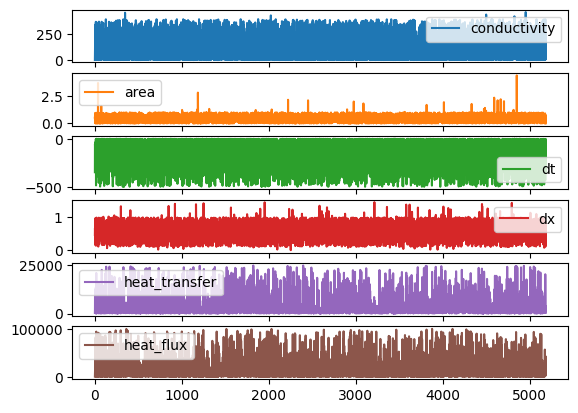

In [78]:
#we are going to plot every single data in the dataset to see how it looks like
dataset.plot(subplots=True)
plt.show()
#saving the plot as a image

In [79]:
#our y or target will be the heat_flx
target = dataset["heat_flux"]
#our x or features will be the rest of the dataset
dados = dataset[["conductivity","area","dt","dx","heat_transfer"]]

In [80]:
print(dados)

      conductivity      area          dt        dx  heat_transfer
0         0.943743  0.513221 -348.191094  0.464913     362.747307
1        65.011603  0.381423  -54.346152  0.669835    2011.868219
2        89.220133  0.892667  -87.739080  0.565425   12358.623272
3       212.141557  0.037116 -337.460107  0.899754    2953.145307
4        17.599319  0.479069  -39.294216  0.163783    2022.798515
...            ...       ...         ...       ...            ...
5183      5.231227  0.620063 -350.124522  0.869912    1305.528936
5184    181.027815  0.537228   -1.679641  0.114923    1421.391282
5185    112.077600  0.707737  -29.802440  0.597094    3959.129131
5186    179.472696  0.047285 -163.590949  0.690034    2011.903726
5187    125.250534  0.011809 -149.031786  0.565363     389.891851

[5188 rows x 5 columns]


In [81]:
print(target)

0         706.804974
1        5274.631060
2       13844.610424
3       79565.449176
4        4222.351658
            ...     
5183     2105.478258
5184     2645.787469
5185     5594.068975
5186    42548.799946
5187    33016.480044
Name: heat_flux, Length: 5188, dtype: float64


In [82]:
target = np.array(target)
dados = np.array(dados)

In [83]:
print(dados)

[[ 9.43743252e-01  5.13221215e-01 -3.48191094e+02  4.64913247e-01
   3.62747307e+02]
 [ 6.50116030e+01  3.81423496e-01 -5.43461521e+01  6.69834615e-01
   2.01186822e+03]
 [ 8.92201326e+01  8.92666741e-01 -8.77390803e+01  5.65425255e-01
   1.23586233e+04]
 ...
 [ 1.12077600e+02  7.07736917e-01 -2.98024404e+01  5.97094176e-01
   3.95912913e+03]
 [ 1.79472696e+02  4.72846174e-02 -1.63590949e+02  6.90033765e-01
   2.01190373e+03]
 [ 1.25250534e+02  1.18090072e-02 -1.49031786e+02  5.65363440e-01
   3.89891851e+02]]


In [84]:
#scaling both the target and the features, keep in mind that we can reverse the scaling later
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = scaler.fit_transform(target.reshape(-1,1))

In [85]:
X_train_full, x_test, y_train_full, y_test = train_test_split(dados, target, test_size=0.25, random_state=42)


In [86]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [87]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3,activation="tanh", input_shape=[5]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation, **options))
        options = {}
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [88]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\lucca\AppData\Local\Temp\ipykernel_3464\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [89]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    "n_neurons": np.arange(10, 256),
    "learning_rate": reciprocal(3e-5, 3e-2),
    "activation": ["tanh"],
}

In [90]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5,n_jobs=1,cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=75,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5,monitor="val_loss")],verbose=2)

Epoch 1/50


c:\Users\lucca\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 - 1s - loss: 0.7017 - val_loss: 0.6012 - 558ms/epoch - 9ms/step
Epoch 2/50
61/61 - 0s - loss: 0.4408 - val_loss: 0.4980 - 107ms/epoch - 2ms/step
Epoch 3/50
61/61 - 0s - loss: 0.4020 - val_loss: 0.4767 - 106ms/epoch - 2ms/step
Epoch 4/50
61/61 - 0s - loss: 0.3958 - val_loss: 0.4707 - 88ms/epoch - 1ms/step
Epoch 5/50
61/61 - 0s - loss: 0.3940 - val_loss: 0.4680 - 82ms/epoch - 1ms/step
Epoch 6/50
61/61 - 0s - loss: 0.3933 - val_loss: 0.4663 - 114ms/epoch - 2ms/step
Epoch 7/50
61/61 - 0s - loss: 0.3929 - val_loss: 0.4663 - 133ms/epoch - 2ms/step
Epoch 8/50
61/61 - 0s - loss: 0.3926 - val_loss: 0.4657 - 84ms/epoch - 1ms/step
Epoch 9/50
61/61 - 0s - loss: 0.3917 - val_loss: 0.4659 - 84ms/epoch - 1ms/step
Epoch 10/50
61/61 - 0s - loss: 0.3906 - val_loss: 0.4638 - 81ms/epoch - 1ms/step
Epoch 11/50
61/61 - 0s - loss: 0.3910 - val_loss: 0.4638 - 108ms/epoch - 2ms/step
Epoch 12/50
61/61 - 0s - loss: 0.3901 - val_loss: 0.4635 - 91ms/epoch - 1ms/step
Epoch 13/50
61/61 - 0s - loss: 0.3895 - va

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001DA570DA440>,
                   n_iter=5, n_jobs=1,
                   param_distributions={'activation': ['tanh'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001DA570DA260>,
                                        'n_hidden': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                     9, 10, 11, 12, 13, 14, 15,
                                                     16, 17, 18, 19, 20],
                                        'n_neurons': array([...
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255])})

In [91]:
model = rnd_search_cv.best_estimator_.model

In [92]:
hist = model.history.history

In [93]:
rnd_search_cv.best_params_

{'activation': 'tanh',
 'learning_rate': 0.00018802848685038655,
 'n_hidden': 14,
 'n_neurons': 70}

In [94]:
model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_429 (Dense)           (None, 70)                420       
                                                                 
 dense_430 (Dense)           (None, 70)                4970      
                                                                 
 dense_431 (Dense)           (None, 70)                4970      
                                                                 
 dense_432 (Dense)           (None, 70)                4970      
                                                                 
 dense_433 (Dense)           (None, 70)                4970      
                                                                 
 dense_434 (Dense)           (None, 70)                4970      
                                                                 
 dense_435 (Dense)           (None, 70)              

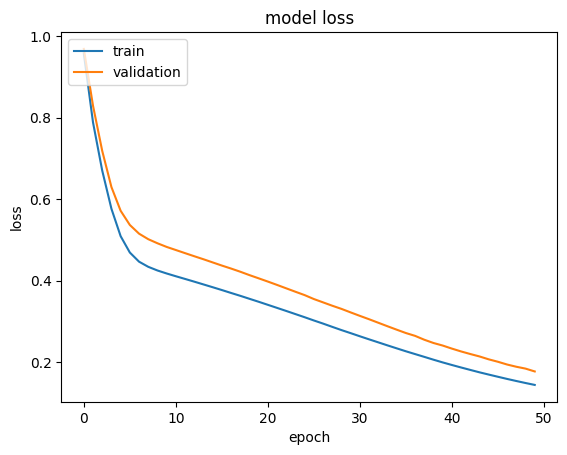

In [95]:
#ploting the loss and the validation loss
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()


In [96]:
mse_test = model.evaluate(x_test, y_test) #mse

41/41 [==============================] - 0s 1ms/step - loss: 0.1632


In [97]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

41/41 [==============================] - 0s 1ms/step


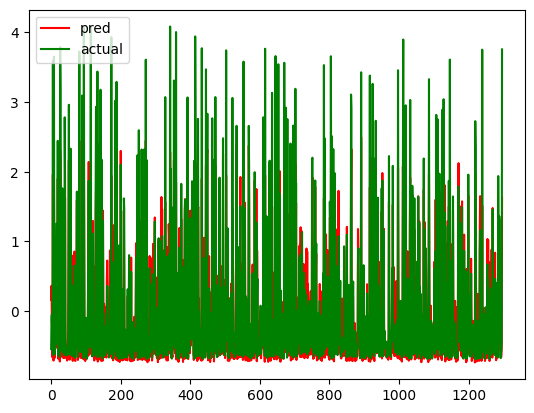

In [98]:
#we have to convert the y_test back to its original shape
#we are going to inverse the scaling of the y_pred, since we scaled it before
#inverse scaling both the y_pred and the y_test
#y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
#y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_pred, color="red", label="pred")
plt.plot(y_test, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()

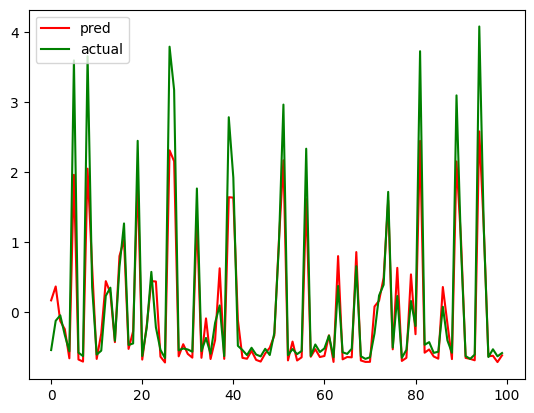

In [99]:
#plotting just the first 100 predictions and values
plt.plot(y_pred[:100], color="red", label="pred")
plt.plot(y_test[:100], color="green", label="actual")
plt.legend(loc="upper left")
plt.show()


In [100]:
mean_squared_error(y_test, y_pred)

0.16321848749469428

In [101]:
#showing the predictions of the first 10 values 
y_pred_inversed = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_inversed = scaler.inverse_transform(y_test.reshape(-1,1))
for i in range(10):
    print("pred: ", y_pred_inversed[i], "actual: ", y_test_inversed[i])


pred:  [17813.346] actual:  [2966.6815776]
pred:  [21963.088] actual:  [11711.7362946]
pred:  [11626.7705] actual:  [13339.02164689]
pred:  [9200.252] actual:  [7459.14024892]
pred:  [504.9463] actual:  [2581.01184033]
pred:  [55322.28] actual:  [89497.53213606]
pred:  [143.86525] actual:  [2193.13801293]
pred:  [-478.74316] actual:  [1157.80922254]
pred:  [57157.16] actual:  [90750.18831576]
pred:  [27795.758] actual:  [21801.15051601]


In [102]:
dataset_test = pd.read_csv('teste.csv')

In [103]:
#setting up the target and the data
target = dataset_test["heat_flux"]
dados = dataset_test[['conductivity','area','dt','dx','heat_transfer']]
#scaling the data
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = target.values.reshape(-1,1)
target = scaler.fit_transform(target)


In [104]:
new_mse_test = model.evaluate(dados, target)

183/183 [==============================] - 0s 1ms/step - loss: 0.1559


In [105]:
#getting the path of every single file that eds with .h5 in the folder
path = os.getcwd()
files = os.listdir(path)
files = [f for f in files if f.endswith(".h5")]

#a partir da linha de cima, teremos uma lista com todos os modelos já salvos na psta

In [106]:
print(files)

['model_10_84_5922.h5', 'model_11_229_11603.h5', 'model_11_248_4373.h5', 'model_14_233_8683.h5', 'model_14_57_87547.h5', 'model_16_93_7214.h5']


In [107]:
print("mse test: ", mse_test)
print("mse new test: ", new_mse_test)

mse test:  0.16321848332881927
mse new test:  0.1558864563703537


In [108]:
#the name of the model will include its amount of hidden layers, its amount of neurons and the amount of indexes in the dataset
#that were used to train it
amount = len(dataset)

name = "model_" + str(rnd_search_cv.best_params_["n_hidden"]) + "_" + str(rnd_search_cv.best_params_["n_neurons"]) +  "_"+ str(amount) + ".h5"
model.save(name)
print("model saved")

model saved


In [109]:
#showing the first 10 predctions and the real values
y_pred = model.predict(dados)
y_pred = y_pred.flatten()

for i in range(10):
    print("pred: ", y_pred[i], "actual: ", target[i])

183/183 [==============================] - 0s 1ms/step
pred:  -0.028190717 actual:  [0.14383479]
pred:  1.4009013 actual:  [2.89159149]
pred:  -0.04340948 actual:  [0.25664841]
pred:  -0.52888054 actual:  [-0.49293873]
pred:  -0.17831688 actual:  [-0.37382883]
pred:  -0.37260514 actual:  [-0.48579226]
pred:  2.2525811 actual:  [2.38314304]
pred:  -0.70931053 actual:  [-0.66977091]
pred:  1.6294767 actual:  [3.56344185]
pred:  -0.25263602 actual:  [-0.59773474]


In [110]:
#Plotting the predictions and the real values
y_pred_inversed = scaler.inverse_transform(y_pred.reshape(-1,1))
target_inversed = scaler.inverse_transform(target.reshape(-1,1))

for i in range(10):
    print("pred: ", y_pred_inversed[i], "actual: ", target_inversed[i])

pred:  [13715.343] actual:  [17289.7404454]
pred:  [43409.445] actual:  [74383.45005907]
pred:  [13399.123] actual:  [19633.81567118]
pred:  [3311.861] actual:  [4058.67008021]
pred:  [10595.977] actual:  [6533.57116779]
pred:  [6558.997] actual:  [4207.16164069]
pred:  [61105.902] actual:  [63818.75641276]
pred:  [-437.1683] actual:  [384.39827572]
pred:  [48158.85] actual:  [88343.35752408]
pred:  [9051.752] actual:  [1881.18725312]


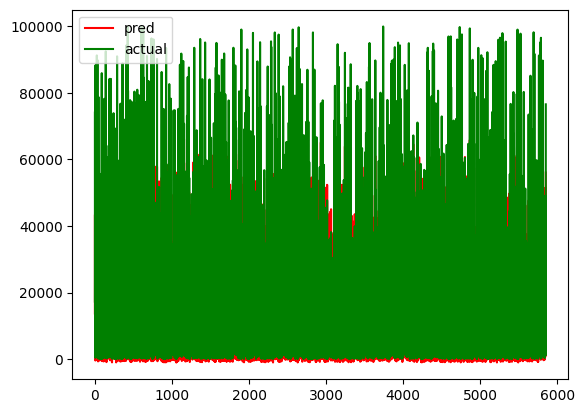

In [111]:
plt.plot(y_pred_inversed, color="red", label="pred")
plt.plot(target_inversed, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()